In [21]:
import os
import torch
import clip
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt

import random
import time
import seaborn as sns

In [2]:
NAME_MODEL = "model_CLIP"

In [3]:
# Для воспроизводимости результатов
random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)

In [4]:
# Пути к данным
dir_train = os.path.join('Worksite-Safety-Monitoring-Dataset', 'train') 
dir_test = os.path.join('Worksite-Safety-Monitoring-Dataset', 'test')  
dir_val = os.path.join('Worksite-Safety-Monitoring-Dataset', 'valid') 

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Загрузка CLIP
model_clip, preprocess = clip.load("ViT-B/32", device=device)

In [7]:
# Текстовые подсказки для классификации
'''
text_prompt = [
    "Фото работника без средств защиты: нет каски и жилета",
    "Фото работника в полной экипировке: каска и защитный жилет",
    "Фото работника только в каске, но без жилета",
    "Фото работника только в жилете, но без каски"
]
'''
text_prompt = [
    "Работник без защиты: нет каски на голове, нет жилета, опасная ситуация",
    "Работники в полной защите: каска на голове, есть жилет, безопасно",
    "Частичная защита: только каска на голове, но жилет отсутствует",
    "Частичная защита: только жилет, но каска на голове отсутствует"
]


In [8]:
text_inputs = torch.cat([clip.tokenize(prompt) for prompt in text_prompt]).to(device)

In [14]:
# Классификация изображения на безопасное/небезопасное с помощью CLIP модели
def clip_classify(image_path):
    # Загрузка и предобработка изображения
    image = Image.open(image_path).convert("RGB")
    # Стандартная предобработка CLIP (нормализация, ресайз) 
    # добавление размерности батча (unsqueeze(0) -> [1, C, H, W]
    # Перемещение тензор на нужное устройство (GPU/CPU)
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    # Расчет вероятностей
    with torch.no_grad(): # Отключаем вычисление градиентов для экономии памяти
        # Получение векторных представлений изображения
        image_features = model_clip.encode_image(image_input)
        # Получение векторных представления текстовых подсказок (prompt)
        text_features = model_clip.encode_text(text_inputs)

        # Вычисление меры схожести между изображением и текстовыми подсказками
        logits_per_image = (image_features @ text_features.T) * model_clip.logit_scale.exp()
        # Преобразование меры схожести в массив вероятности
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]
    
    # Интерпретация результатов
    # Если вероятность безопасного класса больше 0.65, то признаем ситуацию безопасной, иначе - нет
    safety_score = probs[1]  # Вероятность "полная защита"
    is_safe = safety_score > 0.65  # Порог можно настроить 
    # или можно выбирать максимальную вероятность, 
    # если она соответсвует безопасному классу, то безопасно, иначе - нет
    #pred_class_idx = probs.argmax()
    # is_safe = pred_class_idx==1
    
    return {
        'class': 'safe' if is_safe else 'unsafe',  # класс
        'confidence': safety_score if is_safe else 1 - safety_score,  # уверенность
        'probs': dict(zip(text_prompt, probs))     # вероятности для всех классов
    }

In [15]:
# Пример использования
result = clip_classify("72.jpg")
print(f"Prediction: {result['class']} (Confidence: {result['confidence']:.2f})")

Prediction: safe (Confidence: 1.00)


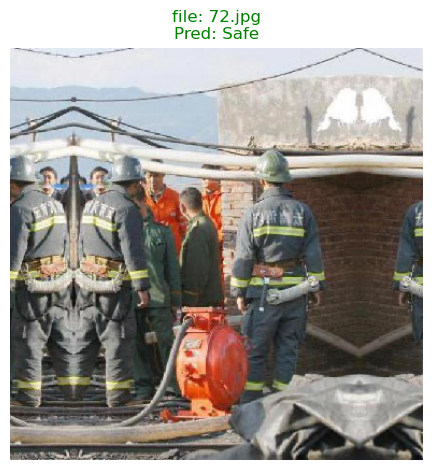

In [16]:
img = load_img("72.jpg", target_size=(384, 384))  # Ресайз изображений
img_array = img_to_array(img) / 255.0           # Нормализация [0, 1]

pred_label = result['class']
    
# Преобразуем метки в текст
pred_class = 'Safe' if pred_label == 'safe' else 'Unsafe'
    
# Отображаем изображение
plt.imshow(img) #, interpolation='hanning')
    
# Устанавливаем цвет текста в зависимости от правильности предсказания
text_color = 'green' if pred_label=='safe' else 'red'
    
# Добавляем подписи
plt.title(f"file: 72.jpg\nPred: {pred_class}", color=text_color)
plt.axis('off')

plt.tight_layout()


Processing unsafe images: 100%|██████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.79it/s]


Time inference: 34.6182906627655

=== CLIP Evaluation Results ===
Processed 200/200 images
Accuracy: 0.5700
Precision: 0.6400
Recall: 0.3200
F1 Score: 0.4267

Classification Report:
              precision    recall  f1-score   support

      unsafe       0.55      0.82      0.66       100
        safe       0.64      0.32      0.43       100

    accuracy                           0.57       200
   macro avg       0.59      0.57      0.54       200
weighted avg       0.59      0.57      0.54       200


Confusion Matrix:
Predicted    0   1  All
Actual                 
0           82  18  100
1           68  32  100
All        150  50  200


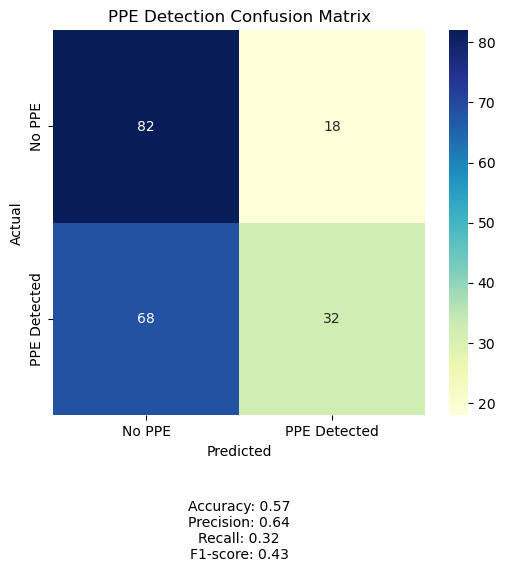

In [27]:
# Оценка на всем тестовом наборе
def evaluate_clip(dir_test):
    # Проверяем существование директорий
    safe_dir = os.path.join(dir_test, 'safe')
    unsafe_dir = os.path.join(dir_test, 'unsafe')
    
    # Получаем списки файлов с проверкой на доступность
    test_safe = [os.path.join(safe_dir, f) for f in os.listdir(safe_dir)] 
    
    test_unsafe = [os.path.join(unsafe_dir, f) for f in os.listdir(unsafe_dir)]                 
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    for img_path in tqdm(test_safe, desc="Processing safe images"):  # тестирование безопасных изображений
        result = clip_classify(img_path)
        pred, prob = result['class'], result['probs']
        all_preds.append(0 if pred=='safe' else 1)
        all_labels.append(0)  # unsafe - класс 1
        all_probs.append(prob)
        
    for img_path in tqdm(test_unsafe, desc="Processing unsafe images"):  # тестирование опасных изображений
        result = clip_classify(img_path)
        pred, prob = result['class'], result['probs']
        all_preds.append(0 if pred=='safe' else 1)
        all_labels.append(1)  # unsafe - класс 1
        all_probs.append(prob)
         
    # Расчет метрик

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1_score': f1_score(all_labels, all_preds, zero_division=0),
        'classification_report': classification_report(all_labels, all_preds, target_names=['unsafe', 'safe']),
        'confusion_matrix': pd.crosstab(np.array(all_labels), np.array(all_preds), 
                          rownames=['Actual'], colnames=['Predicted'], margins=True),
        'support': len(all_labels),
        'processed_images': len(all_labels),
        'total_images': len(test_safe) + len(test_unsafe)
    }
    
    return metrics

# Пример использования
start = time.time()
test_metrics = evaluate_clip(dir_test)
print(f"Time inference: {time.time()-start}")

print("\n=== CLIP Evaluation Results ===")
print(f"Processed {test_metrics['processed_images']}/{test_metrics['total_images']} images")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")
print("\nClassification Report:")
print(test_metrics['classification_report'])
# Матрица ошибок
print("\nConfusion Matrix:")
cm = test_metrics['confusion_matrix']
print(cm)

# Визуализация матрицы ошибок

plt.figure(figsize=(6, 5))
sns.heatmap(cm.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlGnBu',
           xticklabels=['No PPE', 'PPE Detected'],
           yticklabels=['No PPE', 'PPE Detected'])
plt.title('PPE Detection Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Добавляем метрики прямо на график
plt.text(0.5, -0.3, 
        f'Accuracy: {test_metrics['accuracy']:.2f}\n'
        f'Precision: {test_metrics['precision']:.2f}\n'
        f'Recall: {test_metrics['recall']:.2f}\n'
        f'F1-score: {test_metrics['f1_score']:.2f}',
        ha='center', va='center', transform=plt.gca().transAxes)

plt.show()


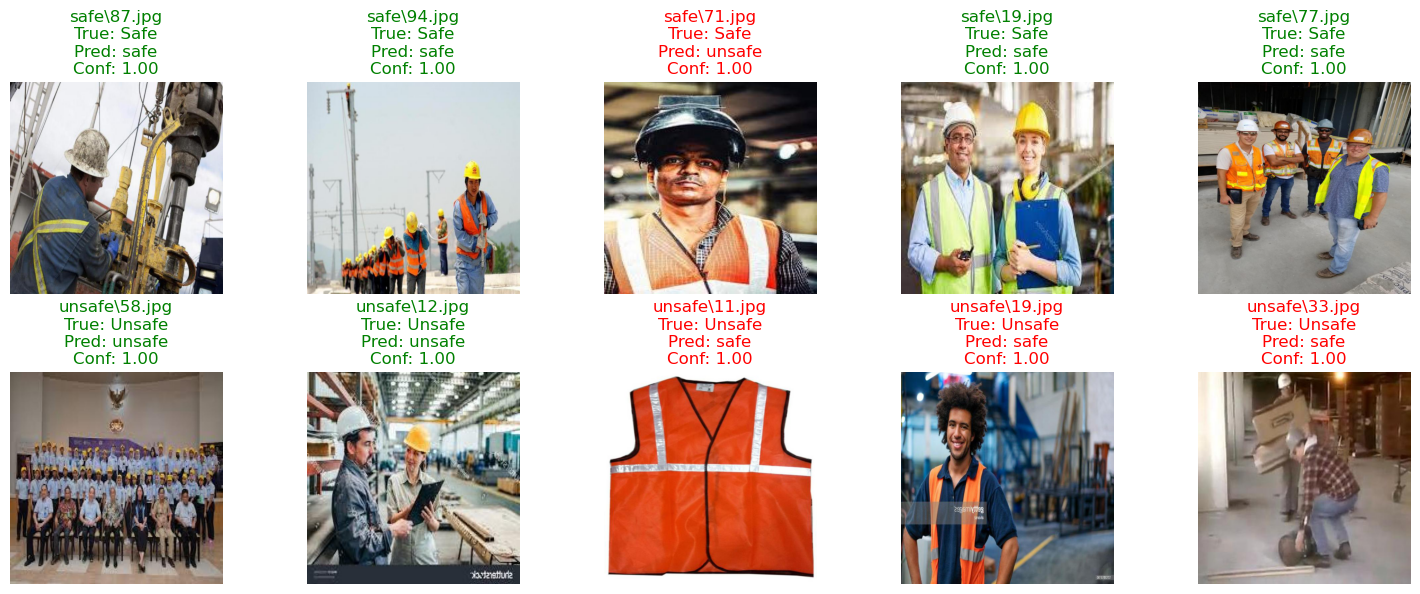

In [18]:
# Визуализация примеров
def show_examples(test_dir, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    # Безопасные примеры
    safe_images = random.sample([f for f in os.listdir(os.path.join(test_dir, 'safe')) if f.endswith('.jpg')], num_samples)
    for i, img_name in enumerate(safe_images):
        img_path = os.path.join(test_dir, 'safe', img_name)
        result = clip_classify(img_path)
        
        img = Image.open(img_path)
        axes[0,i].imshow(img)
        # Устанавливаем цвет текста в зависимости от правильности предсказания
        text_color = 'green' if result['class'] == 'safe' else 'red'
        axes[0,i].set_title(f"{os.path.join('safe', img_name)}\nTrue: Safe\nPred: {result['class']}\nConf: {result['confidence']:.2f}", color=text_color)
        axes[0,i].axis('off')
    
    # Опасные примеры
    unsafe_images = random.sample([f for f in os.listdir(os.path.join(test_dir, 'unsafe')) if f.endswith('.jpg')], num_samples)
    for i, img_name in enumerate(unsafe_images):
        img_path = os.path.join(test_dir, 'unsafe', img_name)
        result = clip_classify(img_path)
        
        img = Image.open(img_path)
        axes[1,i].imshow(img)
        text_color = 'green' if result['class'] == 'unsafe' else 'red'
        axes[1,i].set_title(f"{os.path.join('unsafe', img_name)}\nTrue: Unsafe\nPred: {result['class']}\nConf: {result['confidence']:.2f}", color=text_color)
        axes[1,i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_examples(dir_test)
